In [60]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [62]:
#import os
import datetime 
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import tensorboard
import torchvision

## Load data in class

In [63]:
#Make class from the dataset to use dataloader

from torch.utils.data import Dataset

class amino_acids(Dataset):
    res2num = {
        "ALA": 0, 
        "ASX": 1, 
        "CYS": 2, 
        "ASP": 3, 
        "GLU": 4, 
        "PHE": 5, 
        "GLY": 6, 
        "HIS": 7,
        "ILE": 8, 
        "LYS": 9, 
        "LEU": 10, 
        "MET": 11, 
        "ASN": 12, 
        "PRO": 13, 
        "GLN": 14,
        "ARG": 15, 
        "SER": 16, 
        "THR": 17, 
        "SEC": 18, 
        "VAL": 19, 
        "TRP": 20, 
        "XAA": 21,
        "TYR": 22, 
        "GLX": 23}
    
    old_names = ["ALA", "ASX", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN", 
             "ARG", "SER", "THR", "SEC", "VAL", "TRP", "XAA","TYR", "GLX"]
    
    
    
    def __init__(self):#, split='train'):
        X = np.load('../dataset/theta_train_data.npy').astype(np.float32)
        y = np.load('../dataset/theta_train_target.npy').astype(np.int64)
        
        X_old = X
        n_obs = y.shape[0]
        nonzero_index = (~np.all(y == 0, axis = 0)).nonzero()[0]
        names = []
        for i in nonzero_index:
            names.append(self.old_names[i])
    
        # Then remove zero columns from 'y'
        y = y[:,~np.all(y == 0, axis = 0)]

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_old)
        # Added theta, so now 29 instead of 28 features per point
        X = X_scaled.reshape(n_obs, 100, 29)
        # Get integer values from one-hot encoding
        y_int = np.array([], dtype = np.int64)
        for i in y:
            y_int = np.concatenate((y_int, np.nonzero(i)[0]))

        # Save float and unique arrays of y_int
        y_float = y_int
        unique_y = np.unique(y_float)
        full_x_data = torch.from_numpy(X)
        full_y_data = torch.from_numpy(y_int)
        self.x_data = full_x_data#[SPLITS[split]]
        self.y_data = full_y_data#[SPLITS[split]]
        self.len = len(self.y_data)
        
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    

## Model

In [64]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Conv1d(input_dim, 50, 1, stride=1)
        self.drop_layer_1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(100, 40)
        self.drop_layer_2 = nn.Dropout(p=0.8)
        self.layer3 = nn.Linear(2000, 100)
        self.layer4 = nn.Linear(100, 20)
        

        
    def forward(self, x):
        x = torch.transpose(x, 1,2)
        x = F.relu(self.layer1(x))
        x = self.drop_layer_1(x)
        x = F.relu(self.layer2(x))
        x = x.view(-1,50*20)
        x = self.drop_layer_2(x) # dropout module
        x = F.relu(self.layer3(x))
        x = F.sigmoid(self.layer4(x))
        
        return x

In [65]:
def reset_weights(m):
  '''
    Resetting the weights before each train-val run
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

## Train val and test epochs

In [66]:
def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 

  for data in tqdm(trainloader):
     
    inputs,labels=data[0],data[1]
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
        
  train_loss=running_loss/len(trainloader)
  train_accu=100.*correct/total
  
   
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,train_accu))#train_losses.append(train_loss)
  return train_loss, train_accu
  

In [67]:
def validate(epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for data in tqdm(valloader):
      inputs,labels=data[0],data[1]
       
      outputs=model(inputs)
 
      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
        
      
    
  val_loss=running_loss/len(valloader)
  val_accu=100.*correct/total

 
  print('val Loss: %.3f | Accuracy: %.3f'%(val_loss,val_accu)) 
  return val_loss, val_accu
  

In [68]:
# Define the K-fold Cross Validator
dataset   = amino_acids()
model     = Model(dataset.x_data.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
k_folds = 4
epochs = 200
kfold = KFold(n_splits=k_folds, shuffle=True)

## Tensorboard

In [72]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
%tensorboard --logdir=runs --port=1234

Reusing TensorBoard on port 1234 (pid 2147), started 0:37:02 ago. (Use '!kill 2147' to kill it.)

## Run run run

In [70]:
writer = SummaryWriter()
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    reset_weights(model)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    trainloader = DataLoader(dataset, batch_size = 1000, sampler=train_subsampler)
    valloader = DataLoader(dataset, batch_size = 200, sampler=val_subsampler)
    print('Current Fold is:', fold+1)
    for epoch in range(1,epochs+1): 
        train_loss, train_accu = train(epoch)
        
        val_loss, val_accu = validate(epoch)
        
        writer.add_scalars("Train/Val Loss" + str(fold+1), {'train loss':train_loss, 'val loss': val_loss}, epoch)
        writer.add_scalars("Train/Val Accuracy"+ str(fold+1), {'train accu':train_accu,'val accu':val_accu}, epoch)
        writer.flush()
    break    
        
writer.close()

Reset trainable parameters of layer = Conv1d(29, 50, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=1000, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Current Fold is: 1

Epoch : 1


  0%|                                                                                            | 0/34 [00:00<?, ?it/s]/home/jzeng/env540/python_env/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:05<00:00,  5.79it/s]


Train Loss: 2.946 | Accuracy: 8.456


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.20it/s]


val Loss: 2.912 | Accuracy: 8.467

Epoch : 2


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.19it/s]


Train Loss: 2.897 | Accuracy: 8.779


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.93it/s]


val Loss: 2.873 | Accuracy: 8.449

Epoch : 3


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.94it/s]


Train Loss: 2.870 | Accuracy: 9.060


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.88it/s]


val Loss: 2.854 | Accuracy: 8.566

Epoch : 4


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.12it/s]


Train Loss: 2.856 | Accuracy: 9.075


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.18it/s]


val Loss: 2.846 | Accuracy: 8.808

Epoch : 5


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.05it/s]


Train Loss: 2.848 | Accuracy: 9.171


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.17it/s]


val Loss: 2.840 | Accuracy: 8.656

Epoch : 6


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.25it/s]


Train Loss: 2.838 | Accuracy: 9.186


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 104.23it/s]


val Loss: 2.831 | Accuracy: 9.042

Epoch : 7


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.30it/s]


Train Loss: 2.831 | Accuracy: 9.462


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.10it/s]


val Loss: 2.822 | Accuracy: 9.078

Epoch : 8


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.19it/s]


Train Loss: 2.823 | Accuracy: 9.764


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.68it/s]


val Loss: 2.815 | Accuracy: 9.599

Epoch : 9


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.70it/s]


Train Loss: 2.817 | Accuracy: 10.593


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.51it/s]


val Loss: 2.809 | Accuracy: 10.990

Epoch : 10


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.96it/s]


Train Loss: 2.808 | Accuracy: 13.245


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 132.76it/s]


val Loss: 2.798 | Accuracy: 13.774

Epoch : 11


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.13it/s]


Train Loss: 2.799 | Accuracy: 14.376


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.73it/s]


val Loss: 2.790 | Accuracy: 14.824

Epoch : 12


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.97it/s]


Train Loss: 2.794 | Accuracy: 14.505


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.98it/s]


val Loss: 2.787 | Accuracy: 15.300

Epoch : 13


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.13it/s]


Train Loss: 2.785 | Accuracy: 15.487


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.52it/s]


val Loss: 2.777 | Accuracy: 16.611

Epoch : 14


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.00it/s]


Train Loss: 2.779 | Accuracy: 16.466


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.92it/s]


val Loss: 2.770 | Accuracy: 17.096

Epoch : 15


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.75it/s]


Train Loss: 2.773 | Accuracy: 16.768


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.78it/s]


val Loss: 2.762 | Accuracy: 17.967

Epoch : 16


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.27it/s]


Train Loss: 2.766 | Accuracy: 18.007


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 131.76it/s]


val Loss: 2.758 | Accuracy: 18.407

Epoch : 17


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.45it/s]


Train Loss: 2.761 | Accuracy: 18.609


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.97it/s]


val Loss: 2.750 | Accuracy: 18.533

Epoch : 18


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.27it/s]


Train Loss: 2.758 | Accuracy: 18.767


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.05it/s]


val Loss: 2.747 | Accuracy: 19.377

Epoch : 19


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.83it/s]


Train Loss: 2.752 | Accuracy: 19.698


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.21it/s]


val Loss: 2.743 | Accuracy: 19.458

Epoch : 20


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.18it/s]


Train Loss: 2.749 | Accuracy: 19.881


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.14it/s]


val Loss: 2.739 | Accuracy: 20.320

Epoch : 21


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.93it/s]


Train Loss: 2.744 | Accuracy: 20.276


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.42it/s]


val Loss: 2.736 | Accuracy: 20.311

Epoch : 22


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.93it/s]


Train Loss: 2.740 | Accuracy: 20.222


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 126.86it/s]


val Loss: 2.732 | Accuracy: 20.948

Epoch : 23


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.05it/s]


Train Loss: 2.736 | Accuracy: 20.500


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.69it/s]


val Loss: 2.730 | Accuracy: 20.679

Epoch : 24


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.79it/s]


Train Loss: 2.733 | Accuracy: 20.917


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.40it/s]


val Loss: 2.725 | Accuracy: 21.298

Epoch : 25


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.18it/s]


Train Loss: 2.734 | Accuracy: 20.896


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.25it/s]


val Loss: 2.725 | Accuracy: 21.173

Epoch : 26


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.77it/s]


Train Loss: 2.730 | Accuracy: 21.162


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.03it/s]


val Loss: 2.720 | Accuracy: 21.918

Epoch : 27


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.13it/s]


Train Loss: 2.726 | Accuracy: 21.246


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.61it/s]


val Loss: 2.720 | Accuracy: 21.729

Epoch : 28


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.02it/s]


Train Loss: 2.723 | Accuracy: 21.542


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 130.92it/s]


val Loss: 2.717 | Accuracy: 22.008

Epoch : 29


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.22it/s]


Train Loss: 2.724 | Accuracy: 21.671


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.51it/s]


val Loss: 2.716 | Accuracy: 21.900

Epoch : 30


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.81it/s]


Train Loss: 2.721 | Accuracy: 21.602


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.42it/s]


val Loss: 2.713 | Accuracy: 22.223

Epoch : 31


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.35it/s]


Train Loss: 2.720 | Accuracy: 22.069


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 103.83it/s]


val Loss: 2.712 | Accuracy: 22.340

Epoch : 32


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.18it/s]


Train Loss: 2.717 | Accuracy: 22.060


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 136.36it/s]


val Loss: 2.712 | Accuracy: 22.385

Epoch : 33


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.98it/s]


Train Loss: 2.716 | Accuracy: 21.602


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.28it/s]


val Loss: 2.708 | Accuracy: 22.636

Epoch : 34


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.31it/s]


Train Loss: 2.713 | Accuracy: 22.419


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.97it/s]


val Loss: 2.708 | Accuracy: 22.942

Epoch : 35


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.80it/s]


Train Loss: 2.711 | Accuracy: 22.479


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.87it/s]


val Loss: 2.708 | Accuracy: 22.573

Epoch : 36


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.12it/s]


Train Loss: 2.712 | Accuracy: 22.808


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 135.99it/s]


val Loss: 2.706 | Accuracy: 22.520

Epoch : 37


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.87it/s]


Train Loss: 2.710 | Accuracy: 22.533


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.56it/s]


val Loss: 2.705 | Accuracy: 22.977

Epoch : 38


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.27it/s]


Train Loss: 2.707 | Accuracy: 22.569


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 104.51it/s]


val Loss: 2.703 | Accuracy: 23.328

Epoch : 39


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.26it/s]


Train Loss: 2.706 | Accuracy: 23.057


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.77it/s]


val Loss: 2.702 | Accuracy: 23.148

Epoch : 40


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.32it/s]


Train Loss: 2.705 | Accuracy: 22.883


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.44it/s]


val Loss: 2.700 | Accuracy: 23.489

Epoch : 41


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.83it/s]


Train Loss: 2.704 | Accuracy: 23.200


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.44it/s]


val Loss: 2.697 | Accuracy: 23.534

Epoch : 42


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.90it/s]


Train Loss: 2.704 | Accuracy: 22.889


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.43it/s]


val Loss: 2.698 | Accuracy: 23.498

Epoch : 43


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.24it/s]


Train Loss: 2.701 | Accuracy: 23.173


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.47it/s]


val Loss: 2.696 | Accuracy: 23.615

Epoch : 44


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.88it/s]


Train Loss: 2.701 | Accuracy: 23.398


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.74it/s]


val Loss: 2.697 | Accuracy: 23.525

Epoch : 45


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.32it/s]


Train Loss: 2.698 | Accuracy: 23.299


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 131.40it/s]


val Loss: 2.695 | Accuracy: 24.082

Epoch : 46


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.04it/s]


Train Loss: 2.697 | Accuracy: 23.188


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.95it/s]


val Loss: 2.693 | Accuracy: 23.804

Epoch : 47


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.97it/s]


Train Loss: 2.700 | Accuracy: 23.392


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.78it/s]


val Loss: 2.693 | Accuracy: 23.956

Epoch : 48


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.08it/s]


Train Loss: 2.696 | Accuracy: 23.928


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.12it/s]


val Loss: 2.692 | Accuracy: 24.252

Epoch : 49


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.78it/s]


Train Loss: 2.695 | Accuracy: 23.542


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.86it/s]


val Loss: 2.692 | Accuracy: 23.956

Epoch : 50


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.28it/s]


Train Loss: 2.694 | Accuracy: 23.724


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.26it/s]


val Loss: 2.691 | Accuracy: 24.145

Epoch : 51


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.76it/s]


Train Loss: 2.693 | Accuracy: 23.730


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.58it/s]


val Loss: 2.692 | Accuracy: 24.486

Epoch : 52


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.29it/s]


Train Loss: 2.692 | Accuracy: 23.697


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.79it/s]


val Loss: 2.689 | Accuracy: 24.019

Epoch : 53


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.97it/s]


Train Loss: 2.690 | Accuracy: 23.946


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.75it/s]


val Loss: 2.688 | Accuracy: 24.773

Epoch : 54


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.85it/s]


Train Loss: 2.691 | Accuracy: 23.823


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.23it/s]


val Loss: 2.688 | Accuracy: 24.594

Epoch : 55


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.19it/s]


Train Loss: 2.690 | Accuracy: 23.961


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.69it/s]


val Loss: 2.689 | Accuracy: 24.683

Epoch : 56


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.78it/s]


Train Loss: 2.689 | Accuracy: 24.284


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.88it/s]


val Loss: 2.687 | Accuracy: 24.459

Epoch : 57


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.35it/s]


Train Loss: 2.688 | Accuracy: 23.952


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 130.15it/s]


val Loss: 2.688 | Accuracy: 24.612

Epoch : 58


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.00it/s]


Train Loss: 2.687 | Accuracy: 23.991


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.53it/s]


val Loss: 2.688 | Accuracy: 25.088

Epoch : 59


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.01it/s]


Train Loss: 2.688 | Accuracy: 23.991


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.98it/s]


val Loss: 2.686 | Accuracy: 24.989

Epoch : 60


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.94it/s]


Train Loss: 2.686 | Accuracy: 23.988


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.85it/s]


val Loss: 2.687 | Accuracy: 24.504

Epoch : 61


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.12it/s]


Train Loss: 2.682 | Accuracy: 24.547


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 136.63it/s]


val Loss: 2.685 | Accuracy: 24.971

Epoch : 62


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.76it/s]


Train Loss: 2.683 | Accuracy: 24.425


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.79it/s]


val Loss: 2.684 | Accuracy: 24.980

Epoch : 63


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.22it/s]


Train Loss: 2.684 | Accuracy: 24.607


100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 97.00it/s]


val Loss: 2.685 | Accuracy: 24.818

Epoch : 64


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.23it/s]


Train Loss: 2.683 | Accuracy: 24.293


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.93it/s]


val Loss: 2.686 | Accuracy: 25.079

Epoch : 65


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.86it/s]


Train Loss: 2.682 | Accuracy: 24.419


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.78it/s]


val Loss: 2.683 | Accuracy: 25.150

Epoch : 66


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.31it/s]


Train Loss: 2.681 | Accuracy: 24.443


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.83it/s]


val Loss: 2.685 | Accuracy: 25.088

Epoch : 67


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.89it/s]


Train Loss: 2.680 | Accuracy: 24.616


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.58it/s]


val Loss: 2.681 | Accuracy: 25.016

Epoch : 68


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.13it/s]


Train Loss: 2.679 | Accuracy: 24.443


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 136.48it/s]


val Loss: 2.684 | Accuracy: 25.312

Epoch : 69


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.02it/s]


Train Loss: 2.678 | Accuracy: 24.841


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.60it/s]


val Loss: 2.681 | Accuracy: 25.258

Epoch : 70


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.07it/s]


Train Loss: 2.679 | Accuracy: 24.619


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 104.13it/s]


val Loss: 2.680 | Accuracy: 25.132

Epoch : 71


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.08it/s]


Train Loss: 2.679 | Accuracy: 24.715


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.82it/s]


val Loss: 2.682 | Accuracy: 25.052

Epoch : 72


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.04it/s]


Train Loss: 2.679 | Accuracy: 24.883


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.80it/s]


val Loss: 2.680 | Accuracy: 25.339

Epoch : 73


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.91it/s]


Train Loss: 2.679 | Accuracy: 24.778


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.69it/s]


val Loss: 2.679 | Accuracy: 24.935

Epoch : 74


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.54it/s]


Train Loss: 2.675 | Accuracy: 24.523


100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 68.98it/s]


val Loss: 2.680 | Accuracy: 25.016

Epoch : 75


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.16it/s]


Train Loss: 2.675 | Accuracy: 24.478


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 128.59it/s]


val Loss: 2.680 | Accuracy: 25.222

Epoch : 76


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.08it/s]


Train Loss: 2.676 | Accuracy: 24.820


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.94it/s]


val Loss: 2.681 | Accuracy: 25.070

Epoch : 77


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.14it/s]


Train Loss: 2.677 | Accuracy: 24.823


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.45it/s]


val Loss: 2.679 | Accuracy: 25.438

Epoch : 78


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.93it/s]


Train Loss: 2.676 | Accuracy: 24.802


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.85it/s]


val Loss: 2.680 | Accuracy: 25.644

Epoch : 79


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.99it/s]


Train Loss: 2.675 | Accuracy: 24.718


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.31it/s]


val Loss: 2.680 | Accuracy: 25.007

Epoch : 80


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.22it/s]


Train Loss: 2.674 | Accuracy: 24.658


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.20it/s]


val Loss: 2.679 | Accuracy: 25.177

Epoch : 81


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.91it/s]


Train Loss: 2.673 | Accuracy: 24.694


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.38it/s]


val Loss: 2.679 | Accuracy: 25.465

Epoch : 82


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.08it/s]


Train Loss: 2.671 | Accuracy: 24.942


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.47it/s]


val Loss: 2.678 | Accuracy: 25.276

Epoch : 83


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.94it/s]


Train Loss: 2.671 | Accuracy: 24.709


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.35it/s]


val Loss: 2.678 | Accuracy: 25.321

Epoch : 84


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.06it/s]


Train Loss: 2.671 | Accuracy: 24.694


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.70it/s]


val Loss: 2.678 | Accuracy: 25.519

Epoch : 85


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.77it/s]


Train Loss: 2.672 | Accuracy: 24.706


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.70it/s]


val Loss: 2.678 | Accuracy: 25.249

Epoch : 86


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.77it/s]


Train Loss: 2.671 | Accuracy: 24.721


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.94it/s]


val Loss: 2.678 | Accuracy: 25.366

Epoch : 87


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.33it/s]


Train Loss: 2.669 | Accuracy: 24.616


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.11it/s]


val Loss: 2.677 | Accuracy: 25.483

Epoch : 88


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.87it/s]


Train Loss: 2.668 | Accuracy: 25.137


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 136.21it/s]


val Loss: 2.676 | Accuracy: 25.150

Epoch : 89


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.12it/s]


Train Loss: 2.670 | Accuracy: 25.011


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.72it/s]


val Loss: 2.677 | Accuracy: 25.312

Epoch : 90


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.79it/s]


Train Loss: 2.670 | Accuracy: 25.293


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.60it/s]


val Loss: 2.677 | Accuracy: 25.168

Epoch : 91


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.22it/s]


Train Loss: 2.667 | Accuracy: 25.251


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.70it/s]


val Loss: 2.677 | Accuracy: 25.689

Epoch : 92


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.87it/s]


Train Loss: 2.668 | Accuracy: 24.862


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 125.35it/s]


val Loss: 2.675 | Accuracy: 25.204

Epoch : 93


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.15it/s]


Train Loss: 2.667 | Accuracy: 24.694


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.59it/s]


val Loss: 2.676 | Accuracy: 25.447

Epoch : 94


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.83it/s]


Train Loss: 2.666 | Accuracy: 25.155


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.91it/s]


val Loss: 2.677 | Accuracy: 25.528

Epoch : 95


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.24it/s]


Train Loss: 2.668 | Accuracy: 25.242


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 104.60it/s]


val Loss: 2.676 | Accuracy: 25.168

Epoch : 96


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.16it/s]


Train Loss: 2.666 | Accuracy: 24.984


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.11it/s]


val Loss: 2.676 | Accuracy: 25.474

Epoch : 97


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.67it/s]


Train Loss: 2.667 | Accuracy: 25.020


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.64it/s]


val Loss: 2.676 | Accuracy: 25.554

Epoch : 98


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.29it/s]


Train Loss: 2.666 | Accuracy: 25.164


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.74it/s]


val Loss: 2.674 | Accuracy: 25.653

Epoch : 99


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.92it/s]


Train Loss: 2.667 | Accuracy: 24.909


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 135.70it/s]


val Loss: 2.675 | Accuracy: 25.581

Epoch : 100


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.08it/s]


Train Loss: 2.665 | Accuracy: 25.340


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.59it/s]


val Loss: 2.675 | Accuracy: 25.150

Epoch : 101


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.91it/s]


Train Loss: 2.664 | Accuracy: 24.751


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.69it/s]


val Loss: 2.675 | Accuracy: 25.662

Epoch : 102


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.27it/s]


Train Loss: 2.665 | Accuracy: 25.260


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 104.24it/s]


val Loss: 2.677 | Accuracy: 25.168

Epoch : 103


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.57it/s]


Train Loss: 2.662 | Accuracy: 25.406


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 135.52it/s]


val Loss: 2.674 | Accuracy: 25.483

Epoch : 104


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.23it/s]


Train Loss: 2.662 | Accuracy: 25.197


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 126.43it/s]


val Loss: 2.674 | Accuracy: 25.680

Epoch : 105


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.84it/s]


Train Loss: 2.663 | Accuracy: 25.418


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.02it/s]


val Loss: 2.673 | Accuracy: 25.438

Epoch : 106


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.85it/s]


Train Loss: 2.664 | Accuracy: 25.227


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.55it/s]


val Loss: 2.674 | Accuracy: 25.474

Epoch : 107


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.07it/s]


Train Loss: 2.663 | Accuracy: 25.382


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.65it/s]


val Loss: 2.674 | Accuracy: 25.716

Epoch : 108


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.91it/s]


Train Loss: 2.663 | Accuracy: 25.224


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.50it/s]


val Loss: 2.673 | Accuracy: 25.734

Epoch : 109


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.11it/s]


Train Loss: 2.663 | Accuracy: 25.149


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.87it/s]


val Loss: 2.674 | Accuracy: 26.210

Epoch : 110


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.94it/s]


Train Loss: 2.662 | Accuracy: 25.394


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 127.45it/s]


val Loss: 2.674 | Accuracy: 26.066

Epoch : 111


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.82it/s]


Train Loss: 2.659 | Accuracy: 25.442


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.95it/s]


val Loss: 2.674 | Accuracy: 26.192

Epoch : 112


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.12it/s]


Train Loss: 2.660 | Accuracy: 25.215


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.68it/s]


val Loss: 2.674 | Accuracy: 25.851

Epoch : 113


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.82it/s]


Train Loss: 2.663 | Accuracy: 25.230


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.76it/s]


val Loss: 2.674 | Accuracy: 26.434

Epoch : 114


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.25it/s]


Train Loss: 2.661 | Accuracy: 25.490


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.90it/s]


val Loss: 2.672 | Accuracy: 26.273

Epoch : 115


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.96it/s]


Train Loss: 2.659 | Accuracy: 25.308


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.29it/s]


val Loss: 2.673 | Accuracy: 26.174

Epoch : 116


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.15it/s]


Train Loss: 2.660 | Accuracy: 25.251


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.83it/s]


val Loss: 2.673 | Accuracy: 25.770

Epoch : 117


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.75it/s]


Train Loss: 2.659 | Accuracy: 25.308


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.89it/s]


val Loss: 2.673 | Accuracy: 26.264

Epoch : 118


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.93it/s]


Train Loss: 2.660 | Accuracy: 25.329


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.65it/s]


val Loss: 2.674 | Accuracy: 26.174

Epoch : 119


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.23it/s]


Train Loss: 2.657 | Accuracy: 25.415


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.68it/s]


val Loss: 2.672 | Accuracy: 26.021

Epoch : 120


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.76it/s]


Train Loss: 2.659 | Accuracy: 25.559


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.41it/s]


val Loss: 2.672 | Accuracy: 26.336

Epoch : 121


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.21it/s]


Train Loss: 2.661 | Accuracy: 25.664


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.31it/s]


val Loss: 2.672 | Accuracy: 26.210

Epoch : 122


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.06it/s]


Train Loss: 2.657 | Accuracy: 25.490


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.06it/s]


val Loss: 2.671 | Accuracy: 26.183

Epoch : 123


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.17it/s]


Train Loss: 2.659 | Accuracy: 25.445


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.57it/s]


val Loss: 2.673 | Accuracy: 26.129

Epoch : 124


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.82it/s]


Train Loss: 2.658 | Accuracy: 25.574


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.57it/s]


val Loss: 2.672 | Accuracy: 26.075

Epoch : 125


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.08it/s]


Train Loss: 2.657 | Accuracy: 25.511


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.94it/s]


val Loss: 2.670 | Accuracy: 25.923

Epoch : 126


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.69it/s]


Train Loss: 2.655 | Accuracy: 25.616


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.76it/s]


val Loss: 2.670 | Accuracy: 26.390

Epoch : 127


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.09it/s]


Train Loss: 2.658 | Accuracy: 25.670


100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 98.34it/s]


val Loss: 2.671 | Accuracy: 26.057

Epoch : 128


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.07it/s]


Train Loss: 2.656 | Accuracy: 25.655


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 136.56it/s]


val Loss: 2.669 | Accuracy: 26.246

Epoch : 129


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.93it/s]


Train Loss: 2.656 | Accuracy: 25.487


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.46it/s]


val Loss: 2.671 | Accuracy: 26.300

Epoch : 130


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.99it/s]


Train Loss: 2.655 | Accuracy: 25.840


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.95it/s]


val Loss: 2.671 | Accuracy: 25.824

Epoch : 131


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.04it/s]


Train Loss: 2.657 | Accuracy: 25.556


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.16it/s]


val Loss: 2.672 | Accuracy: 26.291

Epoch : 132


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.18it/s]


Train Loss: 2.656 | Accuracy: 25.472


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.97it/s]


val Loss: 2.672 | Accuracy: 26.273

Epoch : 133


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.84it/s]


Train Loss: 2.656 | Accuracy: 25.583


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.03it/s]


val Loss: 2.672 | Accuracy: 26.129

Epoch : 134


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.15it/s]


Train Loss: 2.652 | Accuracy: 25.742


100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 98.07it/s]


val Loss: 2.672 | Accuracy: 25.680

Epoch : 135


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.25it/s]


Train Loss: 2.653 | Accuracy: 25.625


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.57it/s]


val Loss: 2.670 | Accuracy: 26.219

Epoch : 136


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.21it/s]


Train Loss: 2.655 | Accuracy: 25.885


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.30it/s]


val Loss: 2.671 | Accuracy: 25.994

Epoch : 137


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.83it/s]


Train Loss: 2.655 | Accuracy: 25.798


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.00it/s]


val Loss: 2.672 | Accuracy: 26.210

Epoch : 138


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.87it/s]


Train Loss: 2.655 | Accuracy: 25.484


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.54it/s]


val Loss: 2.672 | Accuracy: 26.237

Epoch : 139


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.00it/s]


Train Loss: 2.652 | Accuracy: 25.870


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.54it/s]


val Loss: 2.670 | Accuracy: 26.228

Epoch : 140


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.88it/s]


Train Loss: 2.654 | Accuracy: 25.598


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 124.87it/s]


val Loss: 2.671 | Accuracy: 26.291

Epoch : 141


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.22it/s]


Train Loss: 2.653 | Accuracy: 25.888


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.43it/s]


val Loss: 2.672 | Accuracy: 26.461

Epoch : 142


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.99it/s]


Train Loss: 2.653 | Accuracy: 25.801


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.10it/s]


val Loss: 2.671 | Accuracy: 26.012

Epoch : 143


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.01it/s]


Train Loss: 2.653 | Accuracy: 25.709


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.38it/s]


val Loss: 2.670 | Accuracy: 25.967

Epoch : 144


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.21it/s]


Train Loss: 2.653 | Accuracy: 25.909


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.22it/s]


val Loss: 2.670 | Accuracy: 26.219

Epoch : 145


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.85it/s]


Train Loss: 2.653 | Accuracy: 26.017


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.75it/s]


val Loss: 2.671 | Accuracy: 26.506

Epoch : 146


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.28it/s]


Train Loss: 2.653 | Accuracy: 25.945


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.28it/s]


val Loss: 2.670 | Accuracy: 26.587

Epoch : 147


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.92it/s]


Train Loss: 2.652 | Accuracy: 25.499


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.01it/s]


val Loss: 2.670 | Accuracy: 25.743

Epoch : 148


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.10it/s]


Train Loss: 2.651 | Accuracy: 25.718


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.17it/s]


val Loss: 2.669 | Accuracy: 26.533

Epoch : 149


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.81it/s]


Train Loss: 2.651 | Accuracy: 25.544


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.55it/s]


val Loss: 2.670 | Accuracy: 26.138

Epoch : 150


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.95it/s]


Train Loss: 2.651 | Accuracy: 25.990


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.34it/s]


val Loss: 2.669 | Accuracy: 26.363

Epoch : 151


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.25it/s]


Train Loss: 2.650 | Accuracy: 25.628


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 127.23it/s]


val Loss: 2.671 | Accuracy: 25.725

Epoch : 152


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.89it/s]


Train Loss: 2.652 | Accuracy: 25.727


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.39it/s]


val Loss: 2.671 | Accuracy: 26.066

Epoch : 153


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.21it/s]


Train Loss: 2.649 | Accuracy: 25.625


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.45it/s]


val Loss: 2.671 | Accuracy: 26.147

Epoch : 154


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.84it/s]


Train Loss: 2.649 | Accuracy: 25.694


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.58it/s]


val Loss: 2.670 | Accuracy: 26.219

Epoch : 155


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.05it/s]


Train Loss: 2.648 | Accuracy: 25.864


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.24it/s]


val Loss: 2.669 | Accuracy: 26.354

Epoch : 156


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.71it/s]


Train Loss: 2.651 | Accuracy: 25.757


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.39it/s]


val Loss: 2.669 | Accuracy: 26.425

Epoch : 157


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.29it/s]


Train Loss: 2.648 | Accuracy: 25.963


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 126.60it/s]


val Loss: 2.669 | Accuracy: 26.111

Epoch : 158


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.79it/s]


Train Loss: 2.649 | Accuracy: 25.885


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.23it/s]


val Loss: 2.670 | Accuracy: 26.120

Epoch : 159


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.80it/s]


Train Loss: 2.649 | Accuracy: 25.736


100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 52.72it/s]


val Loss: 2.670 | Accuracy: 26.407

Epoch : 160


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.16it/s]


Train Loss: 2.648 | Accuracy: 25.733


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.33it/s]


val Loss: 2.669 | Accuracy: 26.345

Epoch : 161


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.86it/s]


Train Loss: 2.648 | Accuracy: 25.840


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.34it/s]


val Loss: 2.670 | Accuracy: 26.488

Epoch : 162


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.08it/s]


Train Loss: 2.648 | Accuracy: 25.864


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.20it/s]


val Loss: 2.668 | Accuracy: 26.300

Epoch : 163


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.89it/s]


Train Loss: 2.648 | Accuracy: 25.745


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.34it/s]


val Loss: 2.669 | Accuracy: 26.363

Epoch : 164


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.28it/s]


Train Loss: 2.648 | Accuracy: 25.571


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 126.20it/s]


val Loss: 2.668 | Accuracy: 26.390

Epoch : 165


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.93it/s]


Train Loss: 2.648 | Accuracy: 25.948


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.65it/s]


val Loss: 2.670 | Accuracy: 26.273

Epoch : 166


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.16it/s]


Train Loss: 2.647 | Accuracy: 25.861


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 104.56it/s]


val Loss: 2.667 | Accuracy: 26.425

Epoch : 167


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.29it/s]


Train Loss: 2.647 | Accuracy: 25.975


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.49it/s]


val Loss: 2.669 | Accuracy: 26.120

Epoch : 168


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.15it/s]


Train Loss: 2.647 | Accuracy: 26.014


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.60it/s]


val Loss: 2.670 | Accuracy: 26.237

Epoch : 169


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.72it/s]


Train Loss: 2.648 | Accuracy: 25.757


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.28it/s]


val Loss: 2.670 | Accuracy: 26.749

Epoch : 170


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.97it/s]


Train Loss: 2.647 | Accuracy: 26.307


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 127.26it/s]


val Loss: 2.668 | Accuracy: 26.264

Epoch : 171


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.17it/s]


Train Loss: 2.646 | Accuracy: 26.014


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.62it/s]


val Loss: 2.669 | Accuracy: 26.183

Epoch : 172


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.95it/s]


Train Loss: 2.646 | Accuracy: 25.999


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.73it/s]


val Loss: 2.669 | Accuracy: 26.722

Epoch : 173


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.07it/s]


Train Loss: 2.646 | Accuracy: 25.966


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.07it/s]


val Loss: 2.669 | Accuracy: 26.470

Epoch : 174


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.02it/s]


Train Loss: 2.646 | Accuracy: 25.882


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 135.82it/s]


val Loss: 2.670 | Accuracy: 26.632

Epoch : 175


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.95it/s]


Train Loss: 2.645 | Accuracy: 26.131


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 136.46it/s]


val Loss: 2.667 | Accuracy: 26.416

Epoch : 176


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.17it/s]


Train Loss: 2.646 | Accuracy: 26.035


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.19it/s]


val Loss: 2.668 | Accuracy: 26.776

Epoch : 177


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.73it/s]


Train Loss: 2.646 | Accuracy: 26.382


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.72it/s]


val Loss: 2.667 | Accuracy: 26.677

Epoch : 178


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.19it/s]


Train Loss: 2.646 | Accuracy: 25.990


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.92it/s]


val Loss: 2.668 | Accuracy: 26.829

Epoch : 179


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.00it/s]


Train Loss: 2.648 | Accuracy: 26.047


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.93it/s]


val Loss: 2.667 | Accuracy: 26.587

Epoch : 180


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.16it/s]


Train Loss: 2.645 | Accuracy: 26.062


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.74it/s]


val Loss: 2.668 | Accuracy: 26.668

Epoch : 181


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.06it/s]


Train Loss: 2.645 | Accuracy: 26.140


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 127.15it/s]


val Loss: 2.670 | Accuracy: 26.686

Epoch : 182


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.93it/s]


Train Loss: 2.647 | Accuracy: 25.954


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.02it/s]


val Loss: 2.669 | Accuracy: 26.731

Epoch : 183


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.28it/s]


Train Loss: 2.644 | Accuracy: 26.167


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.58it/s]


val Loss: 2.669 | Accuracy: 26.695

Epoch : 184


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.84it/s]


Train Loss: 2.646 | Accuracy: 26.158


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.80it/s]


val Loss: 2.668 | Accuracy: 26.542

Epoch : 185


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.13it/s]


Train Loss: 2.642 | Accuracy: 26.113


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.45it/s]


val Loss: 2.666 | Accuracy: 26.551

Epoch : 186


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.81it/s]


Train Loss: 2.645 | Accuracy: 25.987


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.17it/s]


val Loss: 2.665 | Accuracy: 26.874

Epoch : 187


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.34it/s]


Train Loss: 2.643 | Accuracy: 26.265


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.99it/s]


val Loss: 2.668 | Accuracy: 26.632

Epoch : 188


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:05<00:00,  6.39it/s]


Train Loss: 2.644 | Accuracy: 26.173


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.40it/s]


val Loss: 2.670 | Accuracy: 26.542

Epoch : 189


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.10it/s]


Train Loss: 2.642 | Accuracy: 26.131


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.77it/s]


val Loss: 2.670 | Accuracy: 26.461

Epoch : 190


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.94it/s]


Train Loss: 2.644 | Accuracy: 26.110


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.47it/s]


val Loss: 2.668 | Accuracy: 26.381

Epoch : 191


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.07it/s]


Train Loss: 2.644 | Accuracy: 25.786


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 104.82it/s]


val Loss: 2.668 | Accuracy: 26.533

Epoch : 192


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.27it/s]


Train Loss: 2.642 | Accuracy: 26.158


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.86it/s]


val Loss: 2.666 | Accuracy: 26.973

Epoch : 193


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.77it/s]


Train Loss: 2.643 | Accuracy: 26.304


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.81it/s]


val Loss: 2.669 | Accuracy: 26.812

Epoch : 194


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.11it/s]


Train Loss: 2.642 | Accuracy: 26.167


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 127.06it/s]


val Loss: 2.668 | Accuracy: 26.982

Epoch : 195


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.98it/s]


Train Loss: 2.642 | Accuracy: 26.140


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.97it/s]


val Loss: 2.667 | Accuracy: 26.847

Epoch : 196


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.22it/s]


Train Loss: 2.644 | Accuracy: 26.217


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.43it/s]


val Loss: 2.666 | Accuracy: 26.246

Epoch : 197


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.79it/s]


Train Loss: 2.643 | Accuracy: 26.005


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.17it/s]


val Loss: 2.667 | Accuracy: 26.506

Epoch : 198


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.23it/s]


Train Loss: 2.642 | Accuracy: 25.978


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 104.32it/s]


val Loss: 2.668 | Accuracy: 26.605

Epoch : 199


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.24it/s]


Train Loss: 2.642 | Accuracy: 26.203


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.48it/s]


val Loss: 2.669 | Accuracy: 26.722

Epoch : 200


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.24it/s]


Train Loss: 2.642 | Accuracy: 26.134


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.86it/s]

val Loss: 2.668 | Accuracy: 26.829


/home/jzeng/env540/python_env/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


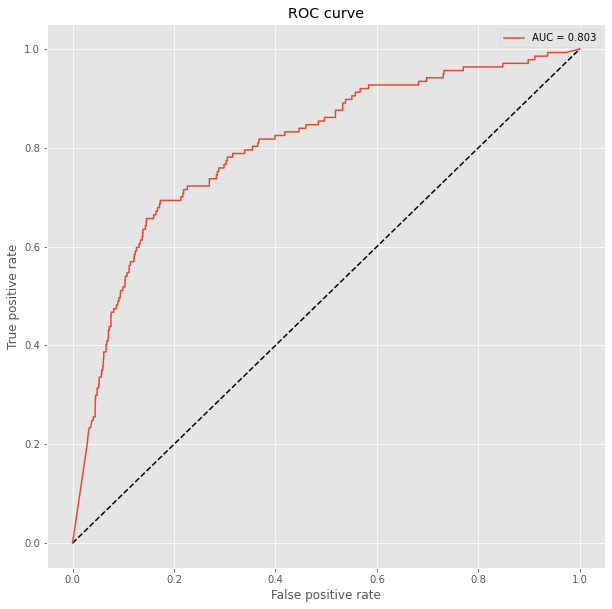

In [71]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    valloader = DataLoader(dataset, batch_size = 200, sampler=val_subsampler)
    if fold == 1:
        for data in valloader:
            inputs,labels=data[0],data[1]
    
    
# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(labels[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(inputs).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();